### MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [172]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions
# %pip install --upgrade scikit-learn

In [173]:
import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

from patsy import dmatrices
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test, index_col="Id")
df_train = pd.read_csv(file_path_train, index_col="Id")

In [175]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### UDFs

### Project Code

#### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows
4. Check for outliers
5. Test for biases after imputations


In [176]:
#checking for datatype
print(df_train.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_train.columns:
    unique_types = set(df_train[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


In [177]:
df_train.shape

(1460, 80)

In [178]:
#check for duplicates
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [179]:
cols = df_train.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_train.rename(columns={col: new_col}, inplace=True)

In [180]:
#Checking if any columns are completely empty
for col in cols:
    if df_train[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

In [181]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_train.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_train.columns if df_train[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_train[col].isnull().sum(), reverse=True)
    
    if df_train[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_train[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

------------- float64 -------------
LotFrontage : 259
GarageYrBlt : 81
MasVnrArea : 8




------------- object -------------
PoolQC : 1453
MiscFeature : 1406
Alley : 1369
Fence : 1179
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
BsmtExposure : 38
BsmtFinType2 : 38
BsmtQual : 37
BsmtCond : 37
BsmtFinType1 : 37
MasVnrType : 8
Electrical : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 3 float type columns with null values. 
2. The maximum number of null values in a column are 259. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing: <br>
&nbsp;&nbsp;&nbsp;&nbsp;<table>
    <tr>
        <th>Column</th>
        <th>Null Values</th>
        <th>Percent Empty</th>
    </tr>
    <tr>
        <td>PoolQC</td>
        <td>1453</td>
        <td>99.5%</td>
    </tr>
    <tr>
        <td>MiscFeature</td>
        <td>1406</td>
        <td>96.3%</td>
    </tr>
    <tr>
        <td>Alley</td>
        <td>1369</td>
        <td>93.8%</td>
    </tr>
    <tr>
        <td>Fence</td>
        <td>1179</td>
        <td>80.7%</td>
    </tr>
    <tr>
        <td>FireplaceQu</td>
        <td>690</td>
        <td>47.3%</td>
    </tr>
</table>
<br>3. For the remainder columns, 'None' will replace any empty values in the column. Using 'None' implies that the feature doesn't apply to that record. Adding another value could incorrectly skew the weight & outcome of that column. After adding 'None', <span style="background-color: yellow;"> we need to ensure the value/area of the corresponding feature is 0 (as imputation could add a non-zero value to it.</span> 

In [182]:
#Running multiple imputations on numeric columns feat
df_numeric = df_train.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_train with the imputed values
for col in df_numeric.columns:
    df_train[col] = df_train[col].where(df_train[col].notnull(), imputed_data[col])

In [183]:
#Replacing null values in object columns with 'None'
for col in col_obj_nulls:
    df_train[col] = df_train[col].fillna('None')

#Dropping columns that more than 45% empty 
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

In [184]:
#Checking no null values remain
cols = df_train.columns.tolist()

for col in cols:
    null_count = df_train[col].isnull().sum()
    if null_count > 0:
        print(f"{col} : {null_count}")

In [185]:
#Ensuring the value/area of the corresponding feature is 0

#If BsmtQual == None then TotalBsmtSF and TotalBsmtSF should be 0
df_train.loc[df_train['BsmtQual'].isnull(), ['TotalBsmtSF', 'BsmtUnfSF']] = 0

#If BsmtFinType2 == None then BsmtFinSF2 should be 0
df_train.loc[df_train['BsmtFinType2'].isnull(), ['BsmtFinSF2']] = 0

#If BsmtFinType1 == None then BsmtFinSF1 should be 0
df_train.loc[df_train['BsmtFinType1'].isnull(), ['BsmtFinSF1']] = 0

In [186]:
#Checking the above logic is being followed (value/area when feature doesn't exist should be 0)

logic_violated = False

#Check for basement quality vs total basement area & unfinished basement area
if not df_train.loc[df_train['BsmtQual'].isnull() & 
                    ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))].empty:
    print("Rows violating BsmtQual logic:")
    print(df_train.loc[df_train['BsmtQual'].isnull() & 
                       ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))])

#Check for first basement quality and first basement area
if not df_train.loc[df_train['BsmtFinType1'].isnull() & 
                (df_train['BsmtFinSF1'] != 0)].empty:
    print("\nRows violating BsmtFinType1 logic:")
    print(df_train.loc[df_train['BsmtFinType1'].isnull() & 
                       (df_train['BsmtFinSF1'] != 0)])

#Check for second basement quality and second basement are
if not df_train.loc[df_train['BsmtFinType2'].isnull() & 
                    (df_train['BsmtFinSF2'] != 0)].empty:
    print("\nRows violating BsmtFinType2 logic:")
    print(df_train.loc[df_train['BsmtFinType2'].isnull() & 
                       (df_train['BsmtFinSF2'] != 0)])

if not logic_violated:
    print("No logic violated.")


No logic violated.


<h5 style="color: blue;">Numeric Columns</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

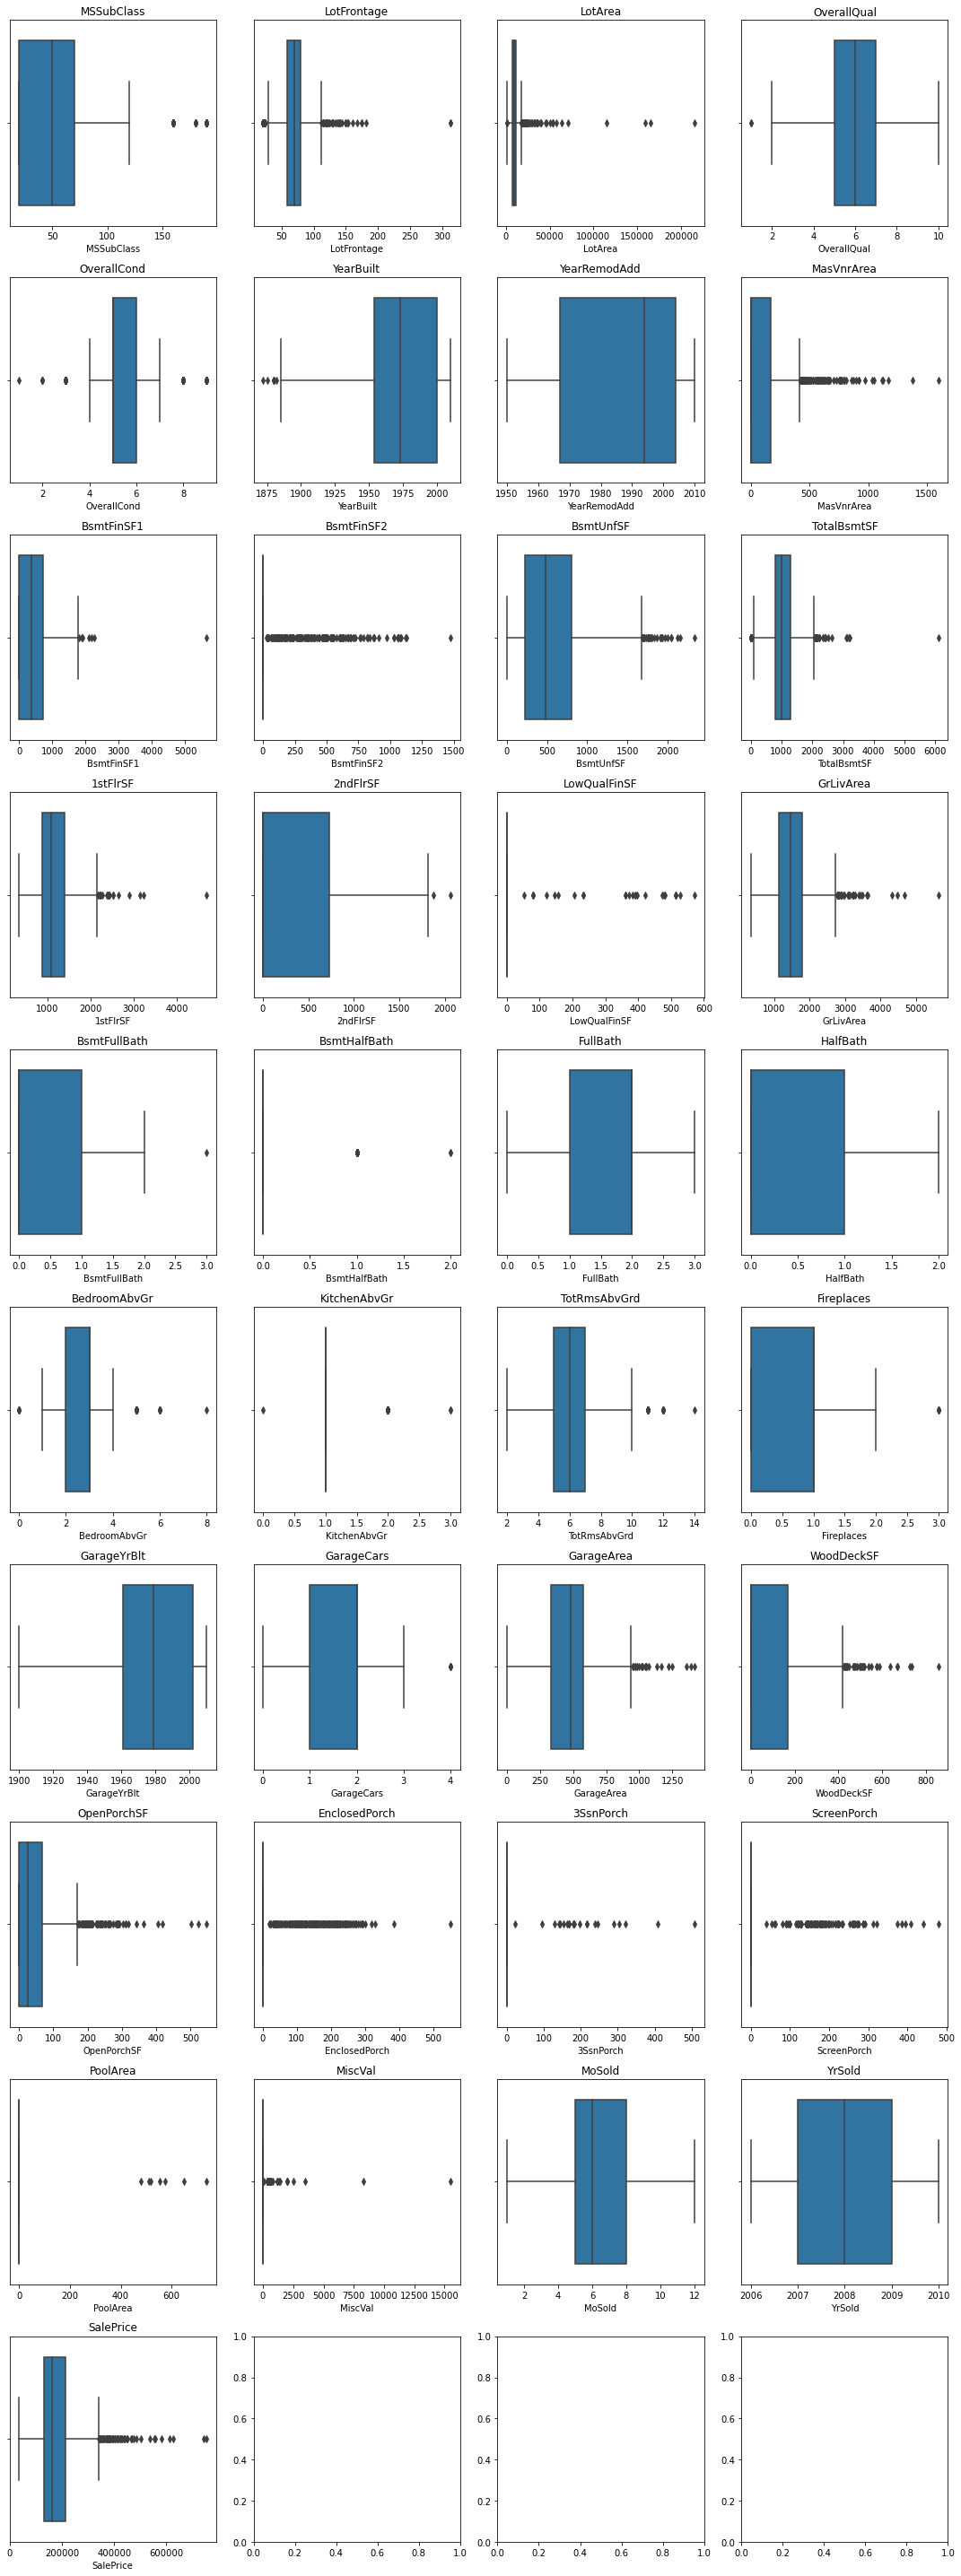

In [187]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots), however it isn't necessary to remove the outliers because:
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. In these cases, other values are technically outliers, but 0 simply indicates the absence of that feature. Removing them would misrepresent the data.
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition. While extreme low or high ratings may appear as outliers, they actually reflect the true condition of the house. Removing these values would distort the representation of house conditions.

<h5 style="color: blue;">Categorical Columns</h5>

1. Test categorical columns
2. Clean and add data wherever necessary

In [188]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_train[col].unique())
    print("\n")

In column MSZoning: 
['RL' 'RM' 'C (all)' 'FV' 'RH']


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'Bnk' 'Low' 'HLS']


In column Utilities: 
['AllPub' 'NoSeWa']


In column LotConfig: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In column Condition1: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


In column Condition2: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


In column BldgType: 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


In column HouseStyle: 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


In column RoofStyle: 
['Gable' 'Hip' 

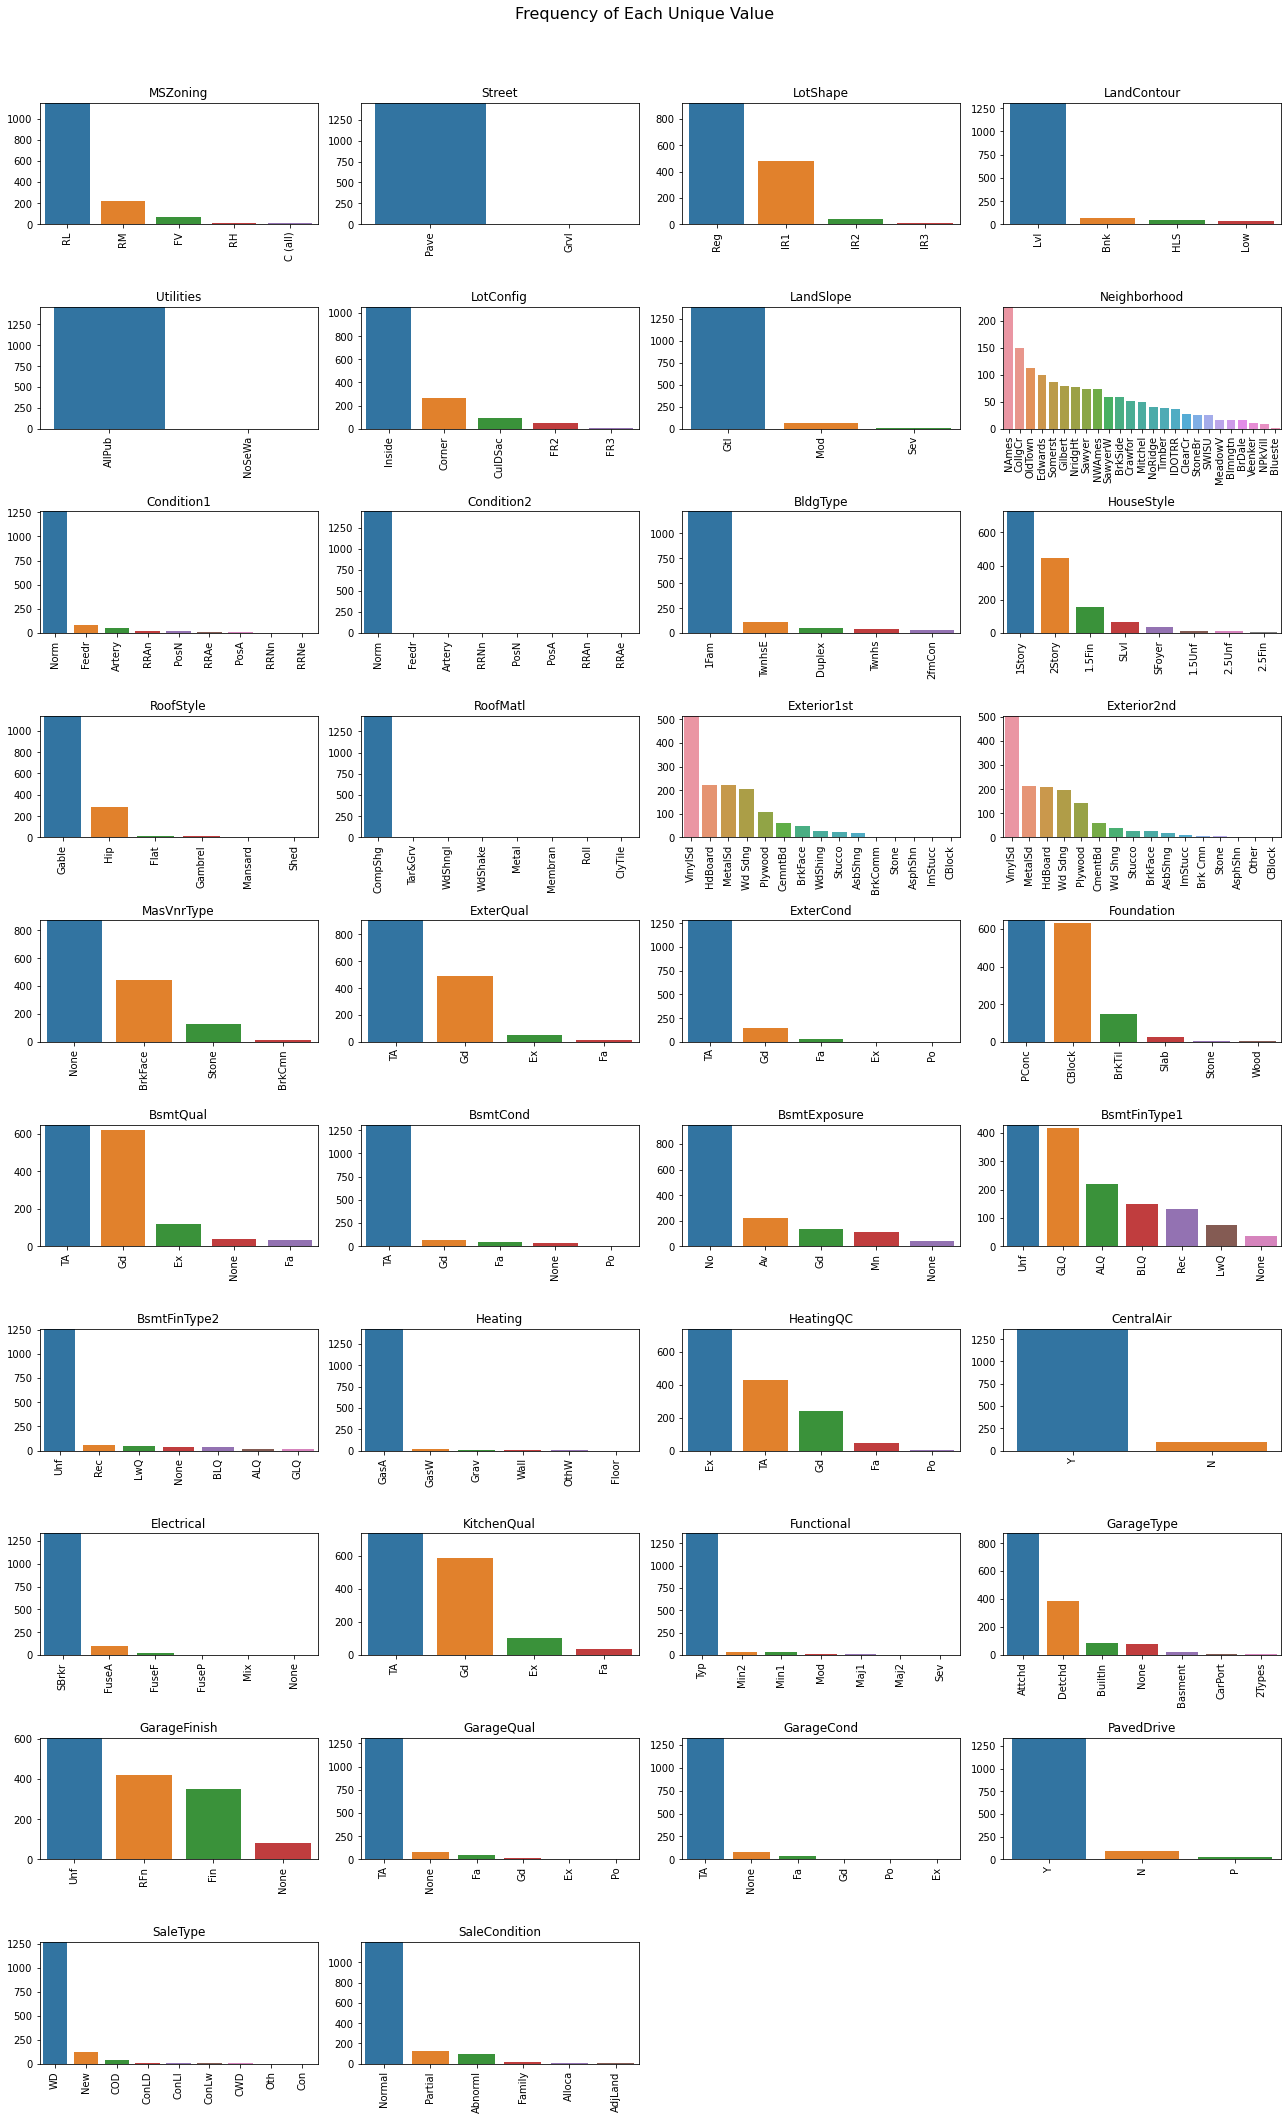

In [189]:
#Plotting the frequency of each unique value
cols = df_train.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_train[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [190]:
#From the graphs, testihng counts for columns that appear skewed in value distribution
test_cols = ['Utilities', 'Street', 'Condition2', 'RoofMatl']

for col in test_cols:
    print(f"Column {col} values:")
    print(df_train[col].value_counts())
    print("\n")

Column Utilities values:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Column Street values:
Pave    1454
Grvl       6
Name: Street, dtype: int64


Column Condition2 values:
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Column RoofMatl values:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64




<h6 style="color: #ff5733;">Unique Value & Frequency Findings:</h6>

Based on the graphs and the 4 columns tested above, one value in each column is over represented. Therefore, in the overall regression model, these columns wouldn't make much of a difference. However, a balance must be maintained between simplifying the model while retaining sensitivity to variance

| Column | Action | Logic |
| :--- | :--- | :--- |
| Utilities | <span style="color: red;">Remove</span> | Column has no variability and will only introduce noise. |
| Street| <span style="color: red;">Remove</span>  | Column has no variability and will only introduce noise. |
| Condition2 | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |
| RoofMtl | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |

This approach balances model efficacy and simplicity

#### Exploratory Data Analysis
1. Statistical analysis of variables


In [191]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [192]:
# Correlation matrix
correlation_matrix = df_train.select_dtypes(include='number').corr()

# Correlation with SalePrice, sorted
print(correlation_matrix['SalePrice'].sort_values(ascending=False).head(15))
# correlation_matrix['SalePrice'].sort_values(ascending=True)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472645
Fireplaces      0.466929
GarageYrBlt     0.463585
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


Housing prices in the dataset are right-skewed and spread widely, ranging from $34,900 to $755,000, with an average around $181K. This wide range reflects the heterogeneity in home size, location, condition, and age.

Key findings:
OverallQual (0.79) and GrLivArea (0.71) show the strongest positive correlation with sale price.

Garage features also matter: GarageCars (0.64) and GarageArea (0.62) boost price.

Other moderately important features include TotalBsmtSF, 1stFlrSF, Fireplaces, and FullBath (correlations from 0.45–0.61).

These findings match buyer expectations — more space, better finishes, and modern upgrades = higher value.

Note: Categorical variables like Neighborhood, ExterQual, or HouseStyle were not included in the correlation matrix, as they require one-hot encoding. These will be handled during the feature engineering phase.

Outliers have already been addressed earlier in the pipeline.

This EDA step focused on uncovering general patterns, which will inform feature selection and multicollinearity checks during modeling.

Quality will be further explored by another team member in a dedicated section.

#### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

In [193]:
# Updated list of all relevant categorical features
categorical_features = [
    'Neighborhood',
    'HouseStyle',
    'ExterQual',
    'KitchenQual',
    'BsmtQual',
    'BsmtCond',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'CentralAir',
    'BldgType',
    'LandContour'
]

# Create the ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep all non-categorical columns
)

# Apply transformation
df_encoded_array = column_transformer.fit_transform(df_train)

# Get dummy variable column names
dummy_columns = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Get the non-categorical column names
non_cat_columns = df_train.drop(columns=categorical_features).columns

# Rebuild the encoded DataFrame
df_model = pd.DataFrame(df_encoded_array, columns=np.append(dummy_columns, non_cat_columns))
df_model.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,12,2008,WD,Normal,250000


This step one-hot encodes all key categorical variables—like neighborhood, house style, and quality ratings—so the model can interpret them numerically, while keeping all other numeric features unchanged.

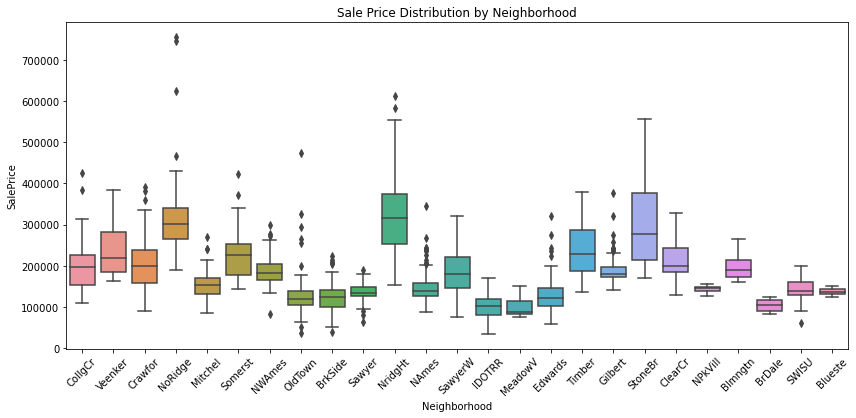

In [194]:
# Boxplot of SalePrice across neighborhoods
plt.figure(figsize=(14, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
plt.xticks(rotation=45)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

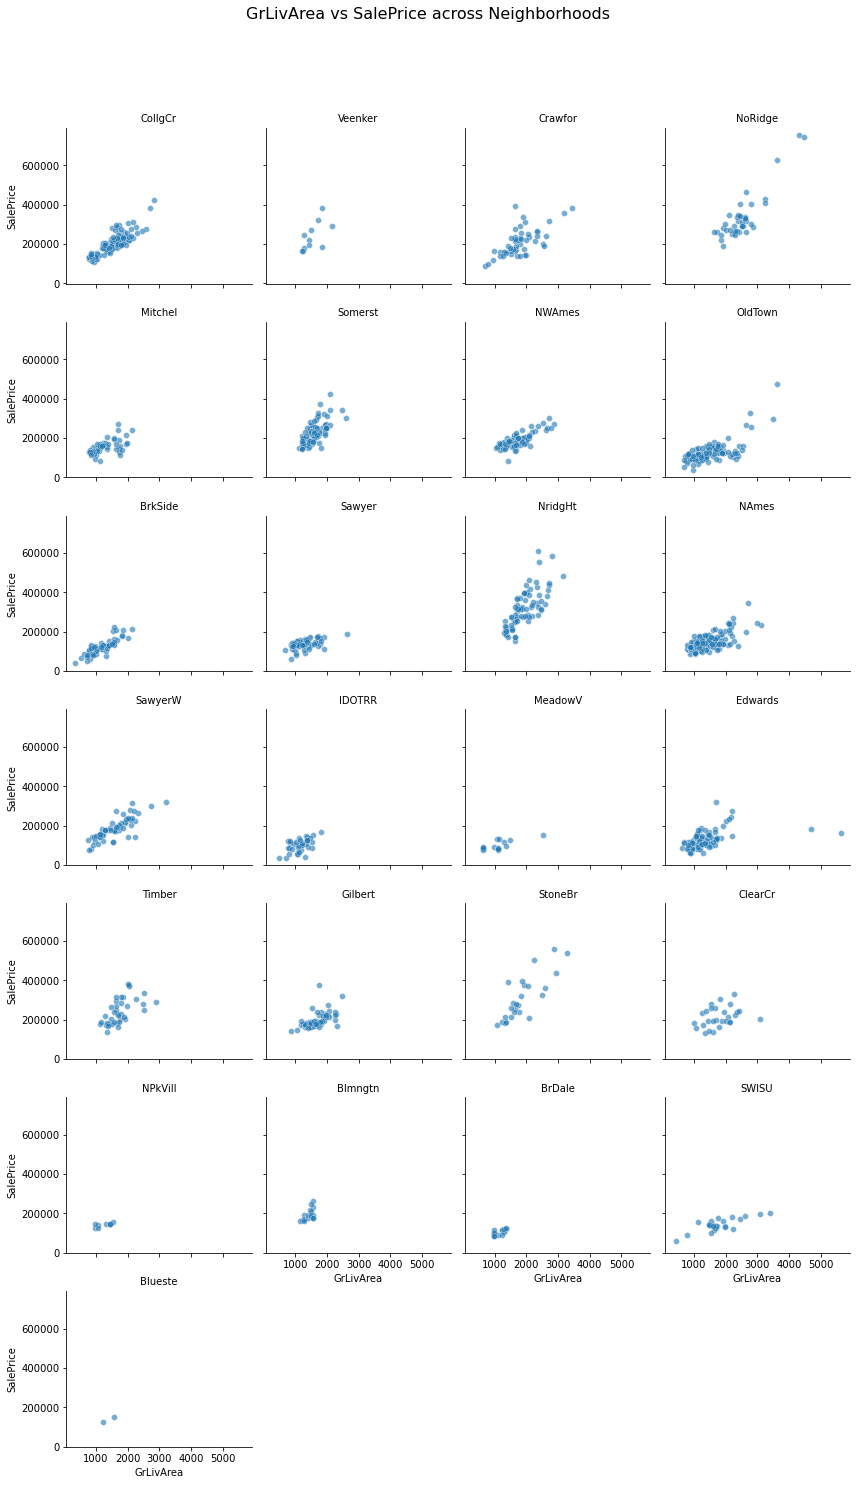

In [195]:
g = sns.FacetGrid(df_train, col="Neighborhood", col_wrap=4, height=3)
g.map_dataframe(sns.scatterplot, x="GrLivArea", y="SalePrice", alpha=0.6)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("GrLivArea vs SalePrice across Neighborhoods", fontsize=16)
plt.show()

In [196]:
# Interaction term between GrLivArea and Neighborhood
model = ols('SalePrice ~ GrLivArea * C(Neighborhood)', data=df_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     114.0
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:22:32   Log-Likelihood:                -17375.
No. Observations:                1460   AIC:                         3.485e+04
Df Residuals:                    1410   BIC:                         3.511e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


We explored whether the relationship between GrLivArea (living space) and SalePrice varied across neighborhoods by including interaction terms in a regression model. However, most of the interaction terms were not statistically significant.

This suggests multicollinearity: in many areas, larger homes tend to cluster in higher-priced neighborhoods, making it difficult for the model to separate the effect of size from the effect of location. As a result, the overlap reduces the precision and usefulness of neighborhood-specific size interactions.

To address this, we looked at housing style breakdowns across neighborhoods and found that size mattered less in uniform, 1-story areas like OldTown and IDOTRR. In contrast, price moved more with size in neighborhoods like NoRidge and StoneBr, which include more varied and custom homes.

This insight led us to introduce a HousingTypeGroup feature — a new classification that captures structural differences (like layout and lot size) across the city. While this reduces neighborhood-level granularity, it adds important context about how much physical space matters, and complements broader location trends already captured by NeighborhoodTier.

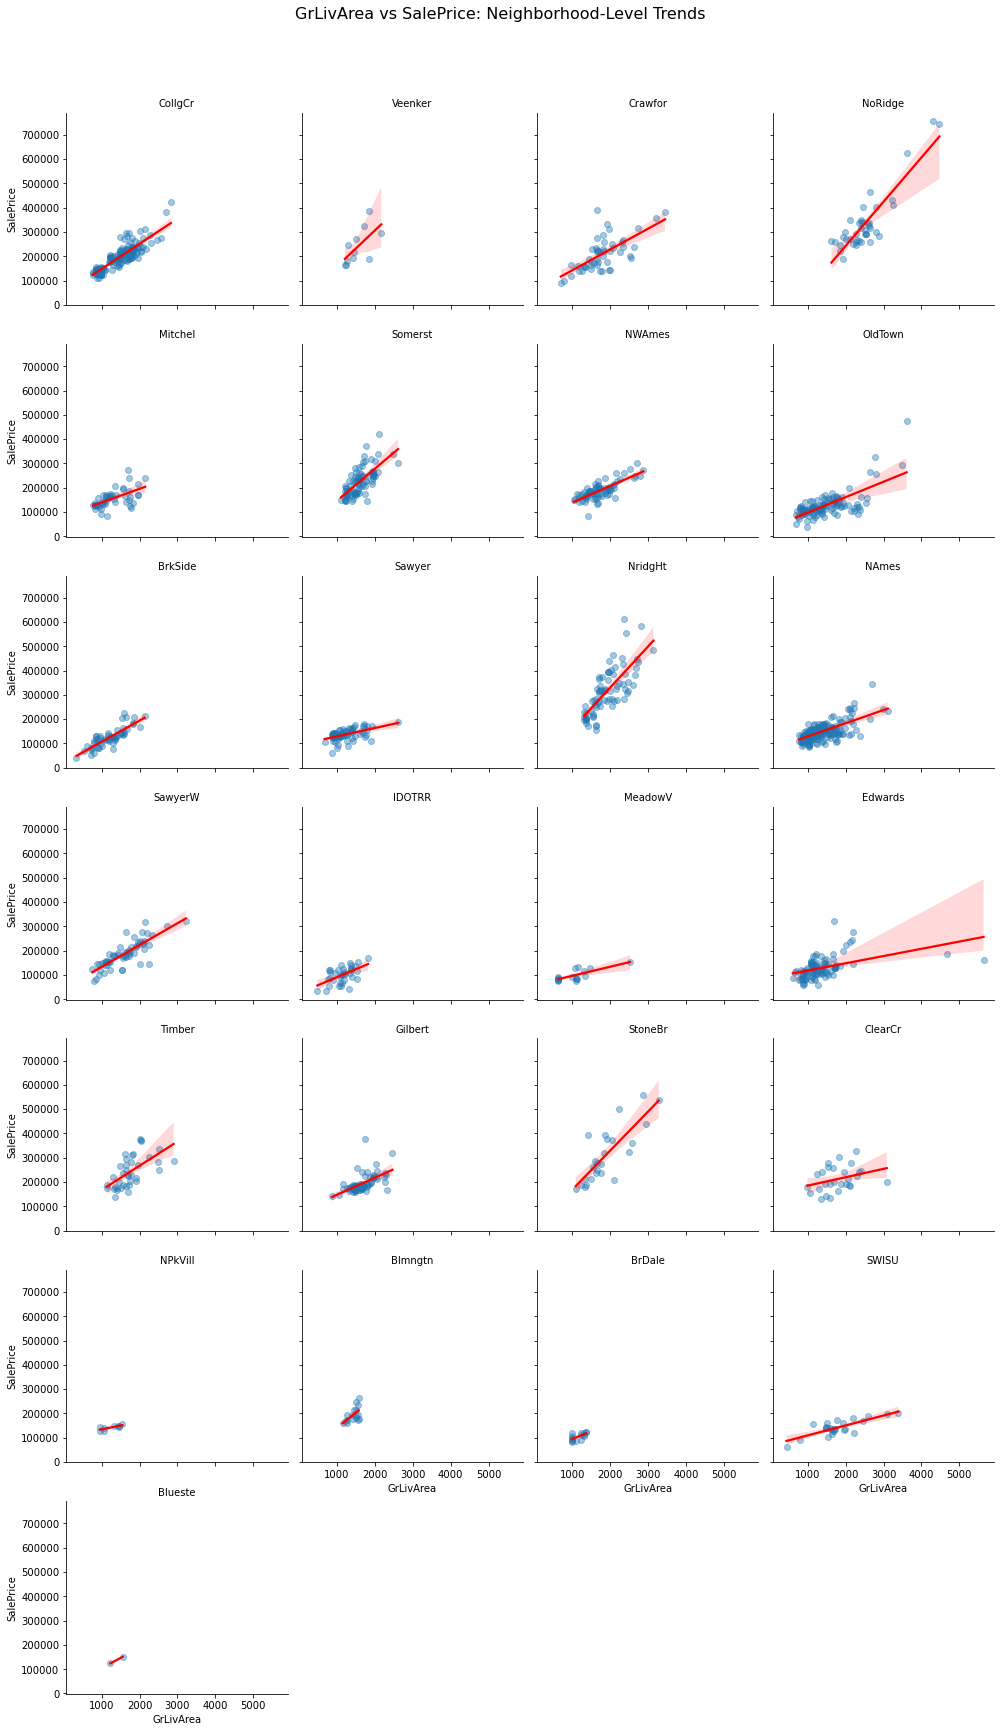

In [197]:
# Plot GrLivArea vs SalePrice, by neighborhood
g = sns.lmplot(
    data=df_train,
    x="GrLivArea",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'red'}
)

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GrLivArea vs SalePrice: Neighborhood-Level Trends", fontsize=16)
plt.show()

This approach:
-Uses all data (no subsetting)
-Avoids overfitting (no bloated interaction model)
-Clearly shows how size impacts price across locations
What we found:
-Some neighborhoods (e.g., NoRidge, StoneBr) show steeper slopes — price increases sharply with size.
- Others (e.g., OldTown, IDOTRR) show flatter slopes — size has less influence.

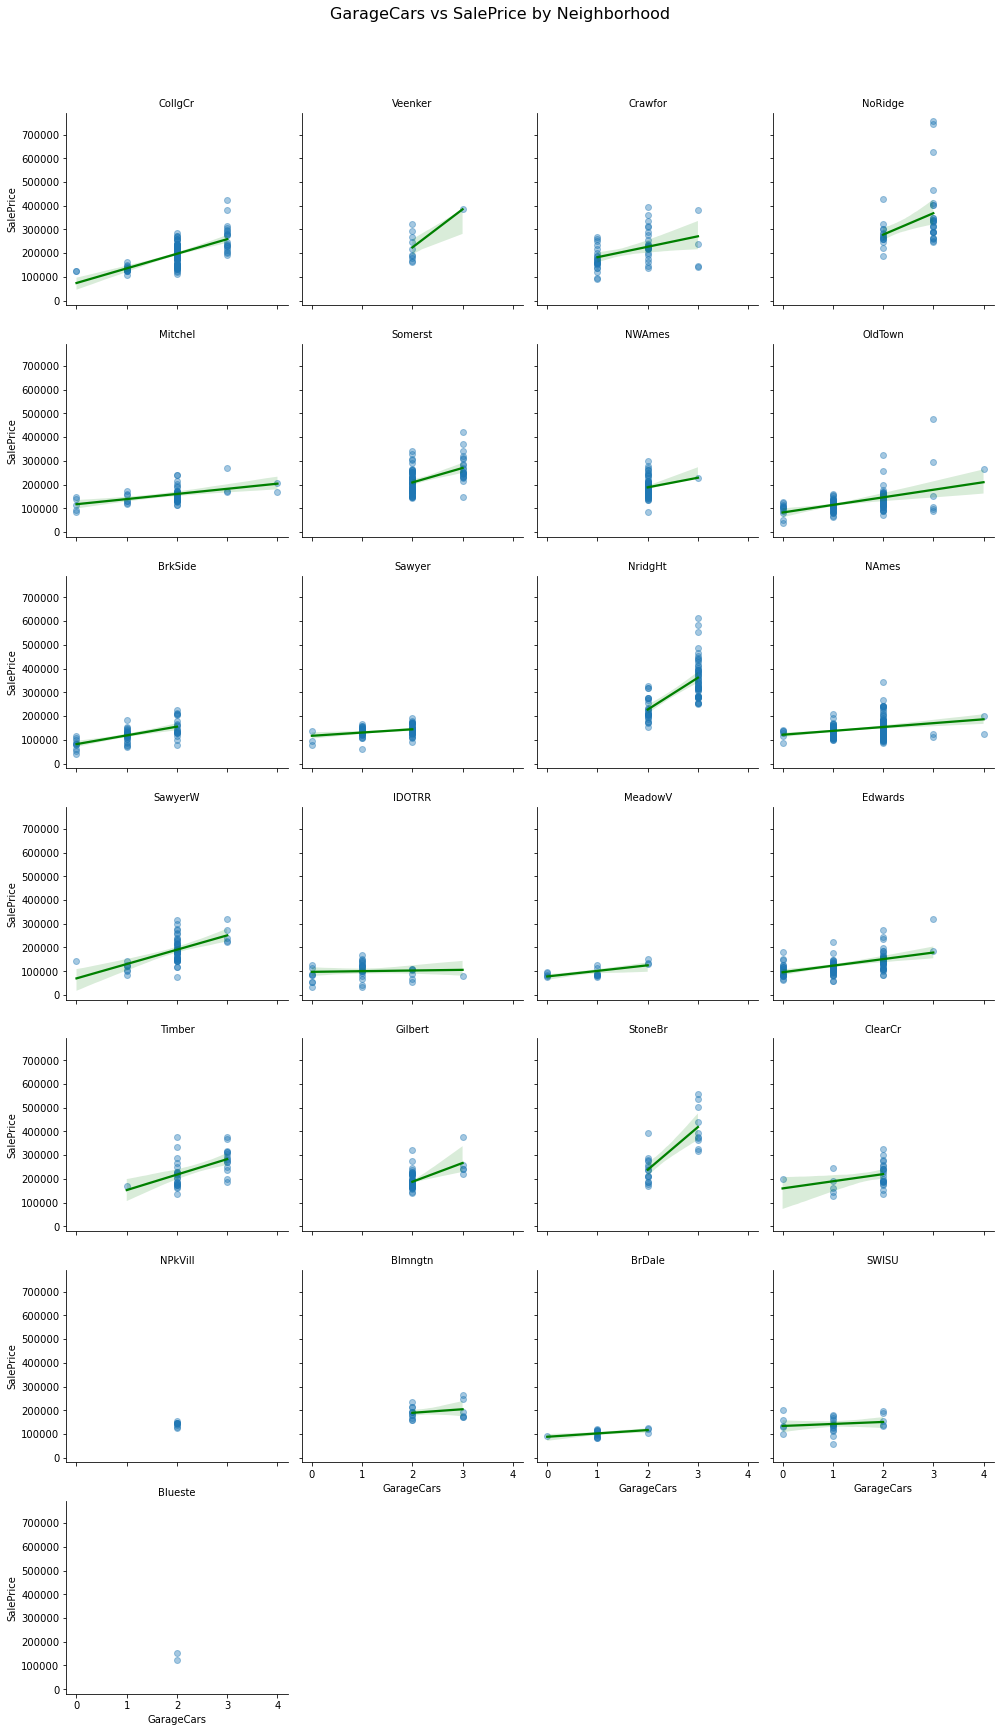

In [198]:
g = sns.lmplot(
    data=df_train,
    x="GarageCars",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'green'}
)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GarageCars vs SalePrice by Neighborhood", fontsize=16)
plt.show()

We examined how garage size and type vary by neighborhood. Higher-income areas like NoRidge and StoneBr tend to have larger garages, while neighborhoods like OldTown or IDOTRR show smaller, less finished garages.
Facet plots suggest that the price premium for garage area is stronger in upscale neighborhoods, while having less impact in others — highlighting another location-specific feature interaction.

In [199]:
# Model with main effects only
model_top = ols('SalePrice ~ OverallQual + GrLivArea + C(Neighborhood)', data=df_train).fit()
model_top.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     203.5
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:22:59   Log-Likelihood:                -17416.
No. Observations:                1460   AIC:                         3.489e+04
Df Residuals:                    1433   BIC:                         3.503e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -3.483e+04   1.15e+04     -3.018      0.003   -5.75e+04   -1.22e+04
C(Neighborhood)[T.Blueste] -3.075e+04   2.77e+04     -1.110      0.267   -8.51e+04    2.36e+04
C(Neighborhood)[T.BrDale]  -4.336e+04    1.3e+04     -3.341      0.001   -6.88e+04   -1.79e+04
C(Neighborhood)[T.BrkSide] -1.303e+04   1.05e+04     -1.246      0.213   -3.35e+04    7474.357
C(Neighborhood)[T.ClearCr]  2.458e+04   1.16e+04      2.124      0.034    1880.417    4.73e+04
C(Neighborhood)[T.CollgCr]  1.141e+04   9496.582      1.202      0.230   -7214.383       3e+04
C(Neighborhood)[T.Crawfor]  1.444e+04   1.05e+04      1.375      0.169   -6157.113     3.5e+04
C(Neighborhood)[T.Edwards] -1.784e+04   9985.734     -1.787      0.074   -3.74e+04    1745.272
C(Neighborhood)[T.Gilbert]  -892.8796   9954.350     -0.090      0.929   -2.04e+04    1.86e+04
C(Neighborhood)[T.IDOTRR]  -2.818e+04   1.11e+04     -2.531      0.011      -5e+04   -6335.193
C(Neighborhood)[T.MeadowV]  -1.91e+04    1.3e+04     -1.469      0.142   -4.46e+04    6400.778
C(Neighborhood)[T.Mitchel]  2030.6121   1.06e+04      0.192      0.847   -1.87e+04    2.27e+04
C(Neighborhood)[T.NAmes]   -4430.0994   9517.291     -0.465      0.642   -2.31e+04    1.42e+04
C(Neighborhood)[T.NPkVill] -1.781e+04   1.53e+04     -1.164      0.245   -4.78e+04    1.22e+04
C(Neighborhood)[T.NWAmes]  -4720.6584   1.01e+04     -0.468      0.640   -2.45e+04    1.51e+04
C(Neighborhood)[T.NoRidge]  6.464e+04   1.09e+04      5.909      0.000    4.32e+04    8.61e+04
C(Neighborhood)[T.NridgHt]  7.159e+04   9994.775      7.163      0.000     5.2e+04    9.12e+04
C(Neighborhood)[T.OldTown] -3.208e+04   9863.373     -3.253      0.001   -5.14e+04   -1.27e+04
C(Neighborhood)[T.SWISU]   -3.664e+04   1.19e+04     -3.073      0.002      -6e+04   -1.33e+04
C(Neighborhood)[T.Sawyer]  -1219.3805   1.02e+04     -0.119      0.905   -2.13e+04    1.88e+04
C(Neighborhood)[T.SawyerW]   303.0986   1.03e+04      0.030      0.976   -1.98e+04    2.04e+04
C(Neighborhood)[T.Somerst]  1.777e+04   9829.881      1.807      0.071   -1515.536     3.7e+04
C(Neighborhood)[T.StoneBr]  6.995e+04   1.17e+04      5.984      0.000     4.7e+04    9.29e+04
C(Neighborhood)[T.Timber]   2.991e+04   1.08e+04      2.762      0.006    8662.963    5.11e+04
C(Neighborhood)[T.Veenker]  4.711e+04   1.43e+04      3.285      0.001     1.9e+04    7.52e+04
OverallQual                 2.095e+04   1162.274     18.026      0.000    1.87e+04    2.32e+04
GrLivArea                     55.5645      2.499     22.237      0.000      50.663      60.466
==============================================================================
Omnibus:                      408.442   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9010.

We built a model combining OverallQual, GrLivArea, and Neighborhood, as these are the top drivers of housing price.
All three variables were strong, independent predictors:
•	OverallQual captured finish and condition
•	GrLivArea measured usable space
•	Neighborhood reflected location-based pricing
This model uses clean, interpretable variables and avoids overfitting while capturing most of the variation in housing prices.

In [200]:
##Creating a Neighborhood Price Group Variable
# Median sale price by neighborhood
neigh_price = df_train.groupby('Neighborhood')['SalePrice'].median().sort_values()

# Create 5 price-based groups with equal price ranges (not equal counts)
price_bins = pd.cut(neigh_price, bins=5, labels=['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5'])

# Map neighborhood groups to each row in the dataset
price_group_map = price_bins.to_dict()
df_train['NeighborhoodPriceGroup'] = df_train['Neighborhood'].map(price_group_map)

# Set reference category to Price_3 for comparison
df_train['NeighborhoodPriceGroup'] = pd.Categorical(
    df_train['NeighborhoodPriceGroup'],
    categories=['Price_3', 'Price_1', 'Price_2', 'Price_4', 'Price_5'],
    ordered=True
)

# regression model
model_pricegroup_ref3 = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + C(NeighborhoodPriceGroup)',
    data=df_train
).fit()

print(model_pricegroup_ref3.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     833.3
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:22:59   Log-Likelihood:                -17456.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1453   BIC:                         3.496e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


We created a NeighborhoodPriceGroup variable by splitting neighborhoods into five groups based on their median sale price, using equal-width price intervals (via pd.cut()). This groups neighborhoods by absolute pricing levels — not by count — making it easier to interpret each group as a distinct market tier.

Using Price_3 as the baseline, the regression shows clear pricing differences: lower-tier neighborhoods sell for less, while upper-tier neighborhoods (especially Price_5) command strong premiums, even after controlling for size and quality. This confirms that location pricing adds important value beyond home features.

In [201]:
##Creating a Housingliving type 
# Define condo-like traits
def condo_score(row):
    score = 0
    if row['LotArea'] < 5000:
        score += 1
    if row['GarageType'] in ['BuiltIn', 'None']:
        score += 1
    if row['HouseStyle'] in ['SFoyer', 'SLvl', '1.5Unf']:
        score += 1
    return score

df_train['CondoScore'] = df_train.apply(condo_score, axis=1)

# Create lot size groups
df_train['LotSizeGroup'] = pd.qcut(df_train['LotArea'], q=4, labels=['Small', 'Medium', 'Large', 'XL'])

# Assign homes into 3 housing types
def classify_housing(row):
    condo_neighs = ['OldTown', 'IDOTRR', 'BrDale', 'SWISU', 'Edwards']
    
    if row['CondoScore'] >= 2 or (row['Neighborhood'] in condo_neighs and row['LotSizeGroup'] == 'Small'):
        return 'Condo'
    elif row['LotSizeGroup'] in ['Large', 'XL'] and row['GarageType'] in ['Attchd', 'Detchd']:
        return 'Large_Home'
    else:
        return 'Mid_Home'

df_train['HousingTypeGroup'] = df_train.apply(classify_housing, axis=1)

# Set Mid_Home as reference for categorical variable
df_train['HousingTypeGroup'] = pd.Categorical(
    df_train['HousingTypeGroup'],
    categories=['Mid_Home', 'Condo', 'Large_Home'],
    ordered=True)

model_midhome_ref = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + C(HousingTypeGroup)',
    data=df_train
).fit()

# Step 6: Show regression results
print(model_midhome_ref.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     975.6
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:22:59   Log-Likelihood:                -17593.
No. Observations:                1460   AIC:                         3.520e+04
Df Residuals:                    1455   BIC:                         3.522e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

We created a custom feature called HousingTypeGroup to classify homes into three structural categories: Condo, Mid_Home, and Large_Home. These are not formal zoning designations, but an engineered grouping based on physical characteristics like lot size, garage type, and house style. For example, homes with small lots, built-in or no garages, and split-level or partial-story layouts were classified as “Condo.” On the other end, homes with large lots and detached or attached garages were considered “Large_Home,” while everything else was grouped as “Mid_Home,” which also serves as the reference category in our model.

We included this feature in a regression alongside GrLivArea (living space) and OverallQual (quality rating) to test whether housing layout and density influence sale price, beyond size and finish. The results confirmed this intuition: Condos sold for about $24K less than Mid_Homes, while Large_Homes sold for roughly $10.5K more, controlling for size and quality. Both housing type and traditional predictors were statistically significant, and the adjusted R² (~0.729) suggests this model explains a substantial portion of price variation. This supports the idea that structural housing type meaningfully impacts home value.

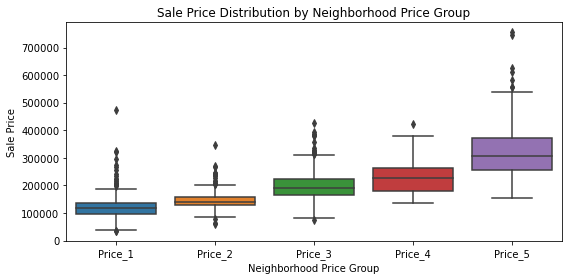

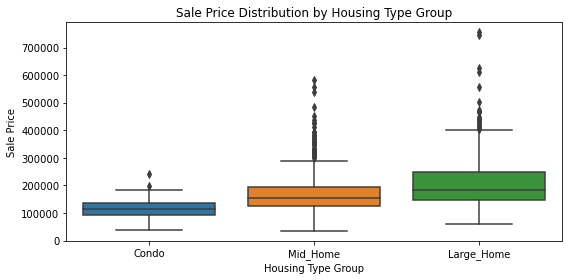

In [202]:
# Boxplot: Sale Price by Neighborhood Price Group
plt.figure(figsize=(8, 4))
sns.boxplot(
    x='NeighborhoodPriceGroup',
    y='SalePrice',
    data=df_train,
    order=['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
)
plt.title('Sale Price Distribution by Neighborhood Price Group')
plt.xlabel('Neighborhood Price Group')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

# Boxplot: Sale Price by Housing Type Group
plt.figure(figsize=(8, 4))
sns.boxplot(
    x='HousingTypeGroup',
    y='SalePrice',
    data=df_train,
    order=['Condo', 'Mid_Home', 'Large_Home']
)
plt.title('Sale Price Distribution by Housing Type Group')
plt.xlabel('Housing Type Group')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

Neighborhood Price Group
→ Shows how sale prices shift across market-based location tiers (Price_1 to Price_5)

Housing Type Group
→ Highlights price differences based on structure and density: Condo, Mid_Home, and Large_Home

These visuals align with your regression models — confirming that both location and structure influence home prices, even before controlling for size and quality. Let me know if you'd like to overlay medians or add a comparison table

In [203]:
##Fireplace Add in
# Regression 1: Neighborhood Price Group with Fireplaces
model_pricegroup_with_fp = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + Fireplaces + C(NeighborhoodPriceGroup)',
    data=df_train
).fit()

# Regression 2: Housing Type Group with Fireplaces
model_housingtype_with_fp = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + Fireplaces + C(HousingTypeGroup)',
    data=df_train
).fit()

# View summaries
print("Neighborhood Price Group Model (with Fireplaces):")
print(model_pricegroup_with_fp.summary())

print("\nHousing Type Group Model (with Fireplaces):")
print(model_housingtype_with_fp.summary())

Neighborhood Price Group Model (with Fireplaces):
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     735.4
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:23:00   Log-Likelihood:                -17439.
No. Observations:                1460   AIC:                         3.489e+04
Df Residuals:                    1452   BIC:                         3.494e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

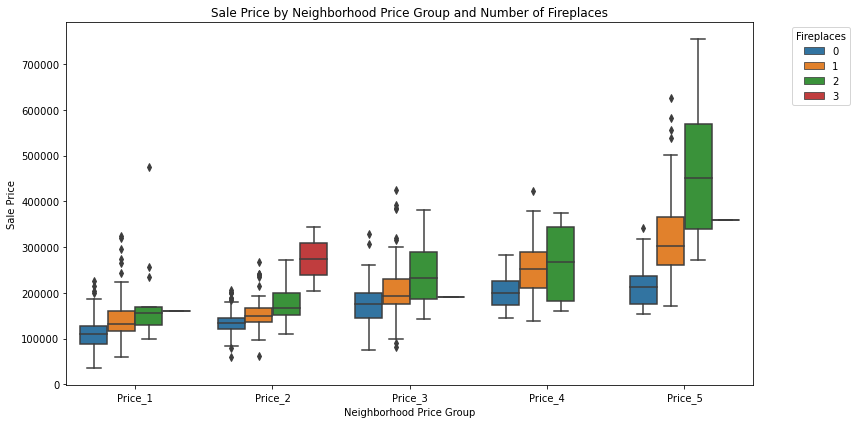

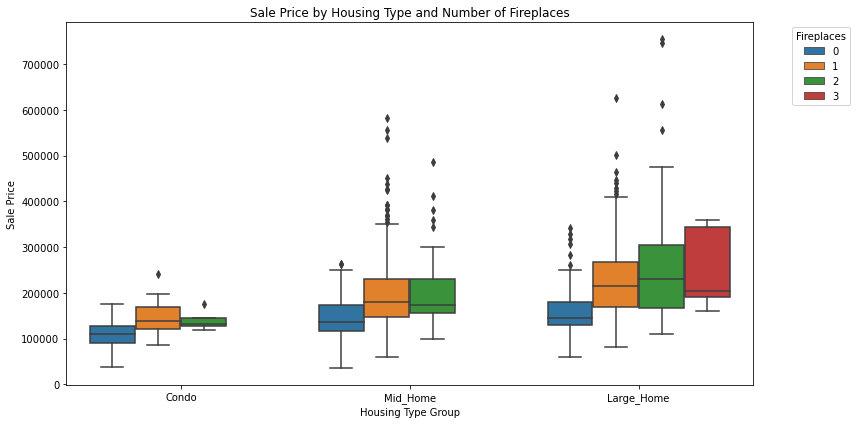

In [204]:
# Boxplot 1: Sale Price by Neighborhood Price Group and Fireplaces
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='NeighborhoodPriceGroup',
    y='SalePrice',
    hue='Fireplaces',
    data=df_train,
    order=['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
)
plt.title('Sale Price by Neighborhood Price Group and Number of Fireplaces')
plt.xlabel('Neighborhood Price Group')
plt.ylabel('Sale Price')
plt.legend(title='Fireplaces', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Boxplot 2: Sale Price by Housing Type Group and Fireplaces
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='HousingTypeGroup',
    y='SalePrice',
    hue='Fireplaces',
    data=df_train,
    order=['Condo', 'Mid_Home', 'Large_Home']
)
plt.title('Sale Price by Housing Type and Number of Fireplaces')
plt.xlabel('Housing Type Group')
plt.ylabel('Sale Price')
plt.legend(title='Fireplaces', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Fireplaces add value, but their impact depends on context. They matter more in higher-priced neighborhoods and larger detached homes, where buyers expect comfort and luxury. In lower-tier areas or condos, the effect is smaller — likely due to tighter budgets or space constraints. The value of a fireplace rises with the market it’s in.

Neighborhood Price Group Model (with GarageCars):
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     757.0
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:23:02   Log-Likelihood:                -17422.
No. Observations:                1460   AIC:                         3.486e+04
Df Residuals:                    1452   BIC:                         3.490e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

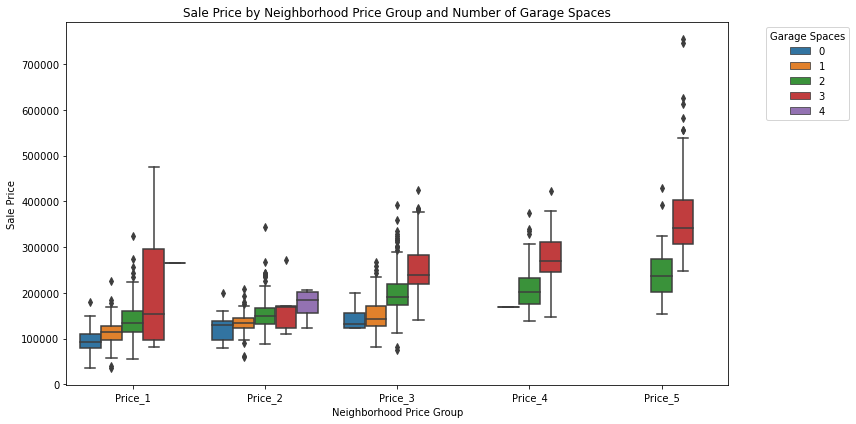

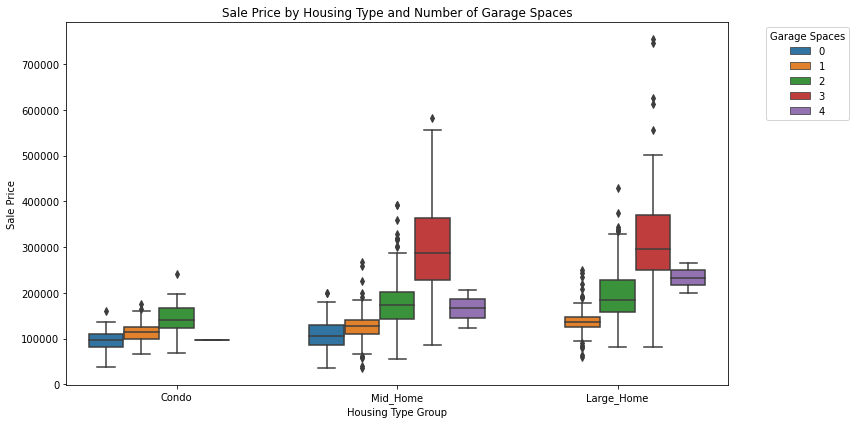

In [205]:
# --- Regression Models ---

# Model 1: Neighborhood Price Group (GarageCars added)
model_pricegroup_with_garage = ols(
    'SalePrice ~ GrLivArea + OverallQual + GarageCars + C(NeighborhoodPriceGroup)',
    data=df_train
).fit()

# Model 2: Housing Type Group (GarageCars added)
model_housingtype_with_garage = ols(
    'SalePrice ~ GrLivArea + OverallQual + GarageCars + C(HousingTypeGroup)',
    data=df_train
).fit()

# View model summaries
print("Neighborhood Price Group Model (with GarageCars):")
print(model_pricegroup_with_garage.summary())

print("\nHousing Type Group Model (with GarageCars):")
print(model_housingtype_with_garage.summary())

# --- Boxplots ---

# Boxplot 1: Sale Price by Neighborhood Price Group and GarageCars
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='NeighborhoodPriceGroup',
    y='SalePrice',
    hue='GarageCars',
    data=df_train,
    order=['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
)
plt.title('Sale Price by Neighborhood Price Group and Number of Garage Spaces')
plt.xlabel('Neighborhood Price Group')
plt.ylabel('Sale Price')
plt.legend(title='Garage Spaces', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Boxplot 2: Sale Price by Housing Type Group and GarageCars
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='HousingTypeGroup',
    y='SalePrice',
    hue='GarageCars',
    data=df_train,
    order=['Condo', 'Mid_Home', 'Large_Home']
)
plt.title('Sale Price by Housing Type and Number of Garage Spaces')
plt.xlabel('Housing Type Group')
plt.ylabel('Sale Price')
plt.legend(title='Garage Spaces', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Garage spaces are a strong predictor of home value. Each additional garage space adds about $15K–$18K to the sale price, even after adjusting for size and quality. The effect is consistent across both neighborhood tiers and housing types, but slightly stronger in larger homes — where buyers may expect more garage capacity.

In [206]:
##VIF
# Define formula using key numerical and categorical predictors
vif_formula = 'SalePrice ~ GrLivArea + OverallQual + GarageCars + Fireplaces + C(NeighborhoodPriceGroup) + C(HousingTypeGroup)'

# Create design matrices (y = target, X = predictors)
y, X = dmatrices(vif_formula, data=df_train, return_type='dataframe')

# Calculate VIF for each column in the predictor matrix
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Display the result
print(vif_data)

                                Variable        VIF
0                              Intercept  48.122227
1   C(NeighborhoodPriceGroup)[T.Price_1]   2.031830
2   C(NeighborhoodPriceGroup)[T.Price_2]   1.621754
3   C(NeighborhoodPriceGroup)[T.Price_4]   1.244216
4   C(NeighborhoodPriceGroup)[T.Price_5]   1.464956
5           C(HousingTypeGroup)[T.Condo]   1.359363
6      C(HousingTypeGroup)[T.Large_Home]   1.210010
7                              GrLivArea   1.806862
8                            OverallQual   2.697629
9                             GarageCars   1.850582
10                            Fireplaces   1.381385


All predictors showed low VIF scores (under 3), meaning no multicollinearity issues. Our variables are stable, and the model results can be trusted.

We explored Condition1 and Condition2 as separate from our location variable (NeighborhoodPriceGroup) to avoid introducing multicollinearity. Including both location tier and condition in the same model can muddy interpretation, since some neighborhoods already reflect access to features like parks or rail lines.

Instead, we paired condition variables with structural and quality factors (e.g., OverallQual, GrLivArea, HousingTypeGroup) to isolate how external surroundings influence price independent of general location. This allows us to evaluate whether certain positive (e.g., near parks) or negative (e.g., near railroad) conditions impact value when home quality is held constant.

In [207]:
model_cond = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + C(Condition1) + C(Condition2)',
    data=df_train
).fit()

In [208]:
df_train['ConditionCombo'] = df_train['Condition1'] + '_' + df_train['Condition2']
def condition_tag(row):
    if 'PosA' in (row['Condition1'], row['Condition2']):
        return 'Near Park'
    elif 'RRAn' in (row['Condition1'], row['Condition2']):
        return 'Near Railroad'
    elif 'Artery' in (row['Condition1'], row['Condition2']):
        return 'Near Main Road'
    else:
        return 'Typical'

df_train['ConditionTag'] = df_train.apply(condition_tag, axis=1)
model_conditiontag = smf.ols(
    'SalePrice ~ GrLivArea + OverallQual + C(ConditionTag)',
    data=df_train
).fit()


### Re-assessing and Removing outliers

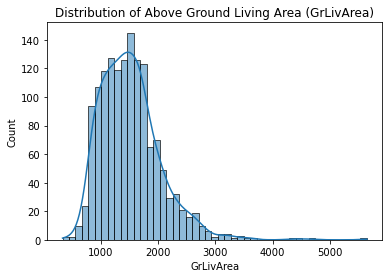

In [209]:
sns.histplot(df_train['GrLivArea'], kde=True)
plt.title("Distribution of Above Ground Living Area (GrLivArea)")
plt.show()

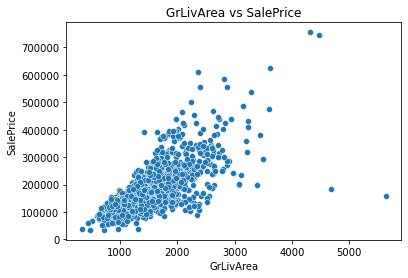

In [210]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title("GrLivArea vs SalePrice")
plt.show()

In [211]:
df_train[['GrLivArea', 'SalePrice']].corr()


,GrLivArea,SalePrice
GrLivArea,1.000000,0.708624
SalePrice,0.708624,1.000000


GrLivArea shows a strong positive correlation (0.71) with SalePrice.


In [212]:
df_train = df_train[df_train['GrLivArea'] < 4000]


Homes over 4000 sqft were removed to reduce skew and stabilize model behavior.


In [213]:
df_train['TotalSqFt'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']

/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/1360486928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TotalSqFt'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']


In [214]:
df_train['LivingAreaPerRoom'] = (df_train['GrLivArea'] / df_train['TotRmsAbvGrd']).replace([np.inf, -np.inf], np.nan)

/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/1491264373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['LivingAreaPerRoom'] = (df_train['GrLivArea'] / df_train['TotRmsAbvGrd']).replace([np.inf, -np.inf], np.nan)


In [215]:
df_train['Has_Basement'] = np.where(df_train['TotalBsmtSF'] > 0, 1, 0)


/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/49571314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Has_Basement'] = np.where(df_train['TotalBsmtSF'] > 0, 1, 0)


In [216]:
df_train['TotalBsmtFinished'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2']


/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/828090511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TotalBsmtFinished'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2']


In [217]:
df_train['SecondVsFirst'] = df_train['2ndFlrSF'] / (df_train['1stFlrSF'] + 1)


/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/1226774755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['SecondVsFirst'] = df_train['2ndFlrSF'] / (df_train['1stFlrSF'] + 1)


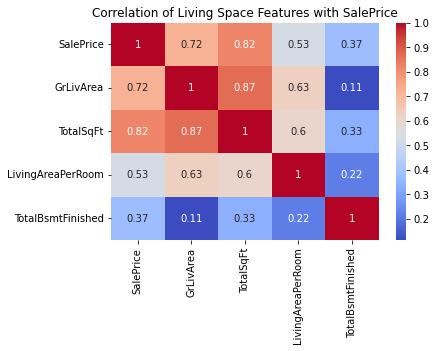

In [218]:
sns.heatmap(df_train[['SalePrice', 'GrLivArea', 'TotalSqFt', 'LivingAreaPerRoom', 'TotalBsmtFinished']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Living Space Features with SalePrice")
plt.show()

We created 5 new features to capture the quality and usability of space, not just the quantity.


In [219]:
if 'AvgRoomSize' not in df_train.columns:
    df_train['AvgRoomSize'] = (df_train['GrLivArea'] / df_train['TotRmsAbvGrd']).replace([np.inf, -np.inf], np.nan)


/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/2773464762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AvgRoomSize'] = (df_train['GrLivArea'] / df_train['TotRmsAbvGrd']).replace([np.inf, -np.inf], np.nan)


In [220]:
df_train['TotalBaths'] = df_train['FullBath'] + 1 * df_train['HalfBath']


/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/3032028652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TotalBaths'] = df_train['FullBath'] + 1 * df_train['HalfBath']


In [221]:
def layout_tag(row):
    if row['TotRmsAbvGrd'] >= 9:
        return 'Many Rooms'
    elif row['TotRmsAbvGrd'] <= 5:
        return 'Few Rooms'
    else:
        return 'Typical Layout'

df_train['LayoutType'] = df_train.apply(layout_tag, axis=1)

/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/2352229536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['LayoutType'] = df_train.apply(layout_tag, axis=1)


We added `AvgRoomSize`, `TotalBaths`, and `LayoutType` to reflect how space is experienced, not just measured.


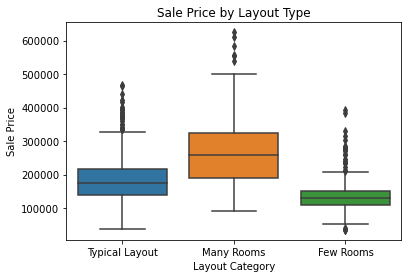

In [222]:
sns.boxplot(x='LayoutType', y='SalePrice', data=df_train)
plt.title('Sale Price by Layout Type')
plt.xlabel('Layout Category')
plt.ylabel('Sale Price')
plt.show()

/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/949397507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TotalBaths'] = df_train['FullBath'] + 1 * df_train['HalfBath']


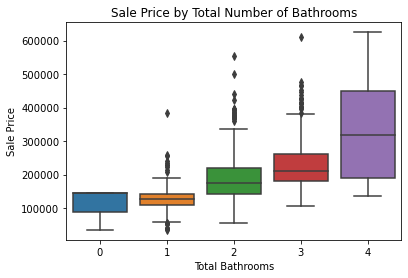

In [223]:
df_train['TotalBaths'] = df_train['FullBath'] + 1 * df_train['HalfBath']

sns.boxplot(x='TotalBaths', y='SalePrice', data=df_train)
plt.title("Sale Price by Total Number of Bathrooms")
plt.xlabel("Total Bathrooms")
plt.ylabel("Sale Price")
plt.show()

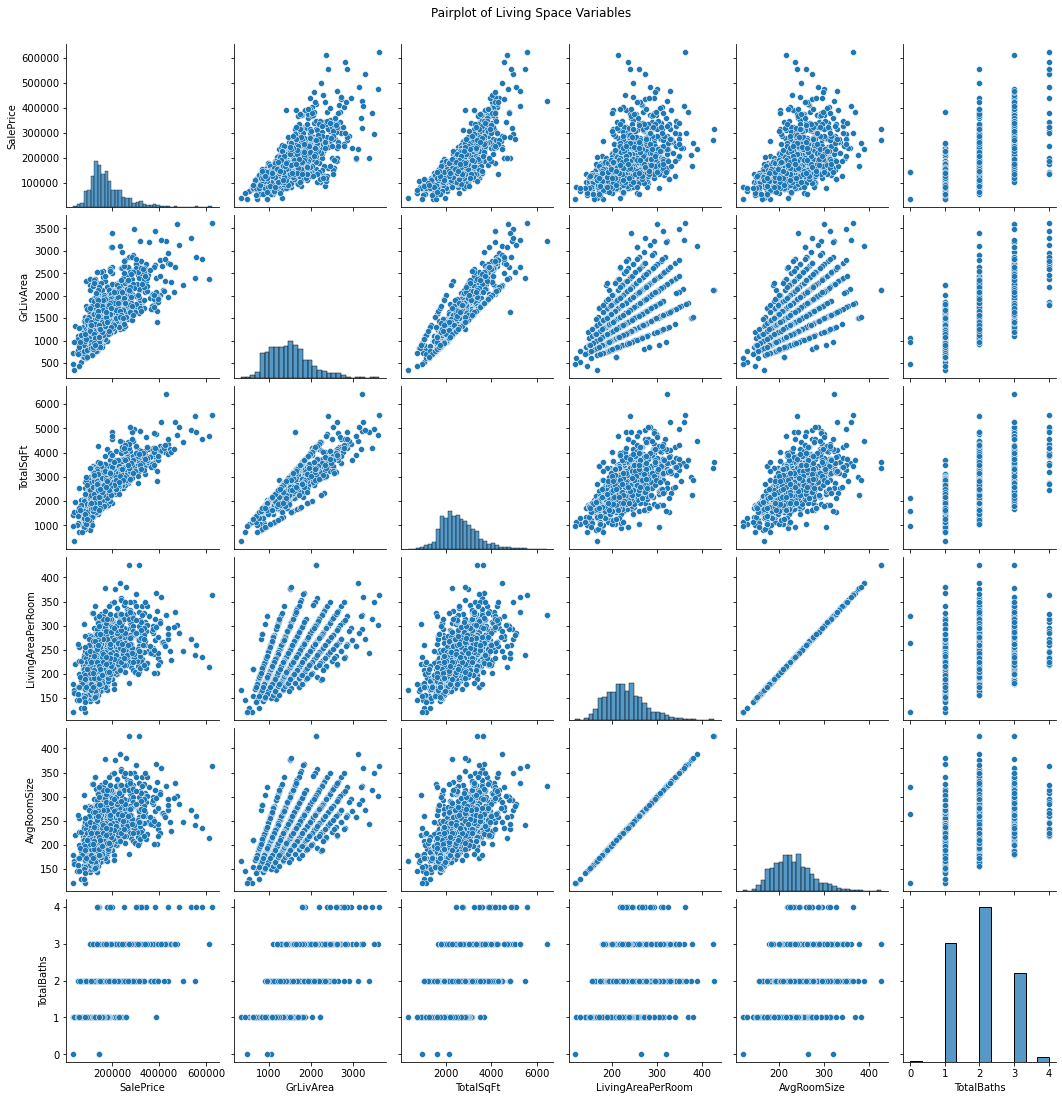

In [224]:
living_features = ['SalePrice', 'GrLivArea', 'TotalSqFt', 'LivingAreaPerRoom', 'AvgRoomSize', 'TotalBaths']

sns.pairplot(df_train[living_features].dropna())
plt.suptitle("Pairplot of Living Space Variables", y=1.02)
plt.show()


- `GrLivArea` and `TotalSqFt` both show strong positive linear relationships with `SalePrice`.
- `LivingAreaPerRoom` and `AvgRoomSize` have more scattered relationships, indicating layout efficiency may play a secondary role compared to overall size.
- `TotalBaths` shows a mild positive correlation with `SalePrice` but some variation, especially in homes with more than 3 baths.
- `TotalSqFt` and `GrLivArea` are highly collinear, which is expected since they are structurally related.

This plot supports the idea that engineered features like `TotalSqFt` and `TotalBaths` contribute valuable signals to price prediction, while `AvgRoomSize` and `LivingAreaPerRoom` provide additional nuance about usability of space.

In [225]:
model1 = ols('SalePrice ~ GrLivArea', data=df_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1570.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):          1.94e-233
Time:                        17:23:14   Log-Likelihood:                -17909.
No. Observations:                1456   AIC:                         3.582e+04
Df Residuals:                    1454   BIC:                         3.583e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.258e+04   4453.274      2.825      0.0

In [226]:
df_train['Log_SalePrice'] = np.log(df_train['SalePrice'])
df_train['Log_GrLivArea'] = np.log(df_train['GrLivArea'])
model2 = ols('Log_SalePrice ~ Log_GrLivArea', data=df_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_SalePrice   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     1686.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):          2.14e-245
Time:                        17:23:14   Log-Likelihood:                -156.43
No. Observations:                1456   AIC:                             316.9
Df Residuals:                    1454   BIC:                             327.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.5932      0.157     35.693

/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/866967843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Log_SalePrice'] = np.log(df_train['SalePrice'])
/var/folders/bh/yfzvzppj5k93kvdphxn5z1b40000gn/T/ipykernel_33851/866967843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Log_GrLivArea'] = np.log(df_train['GrLivArea'])


In [227]:
model3 = ols('SalePrice ~ GrLivArea + TotalSqFt + LivingAreaPerRoom + Has_Basement + TotalBsmtFinished + SecondVsFirst', data=df_train).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     561.2
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:23:14   Log-Likelihood:                -17568.
No. Observations:                1456   AIC:                         3.515e+04
Df Residuals:                    1449   BIC:                         3.519e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2330.1827   9468.29

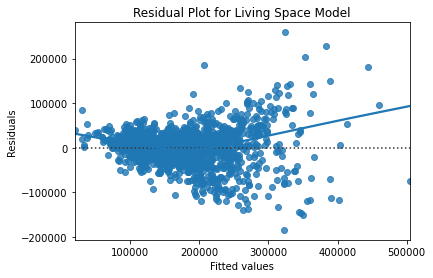

In [228]:
sns.residplot(x=model3.fittedvalues, y=model3.resid, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Living Space Model")
plt.show()

In [229]:
X = df_train[['GrLivArea', 'TotalSqFt', 'LivingAreaPerRoom', 'Has_Basement', 'TotalBsmtFinished', 'SecondVsFirst']].copy()
X = X.dropna()
X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

             feature        VIF
0              const  73.454194
1          GrLivArea  14.609545
2          TotalSqFt  12.502261
3  LivingAreaPerRoom   1.720223
4       Has_Basement   1.521832
5  TotalBsmtFinished   1.349289
6      SecondVsFirst   3.188711


/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


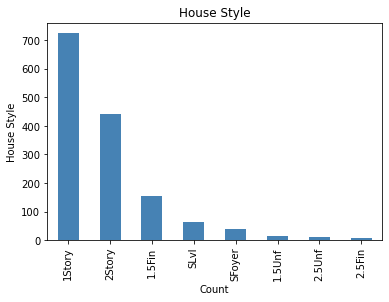

In [230]:
ax = df_train['HouseStyle'].value_counts()\
.plot(kind='bar', color='steelblue', title='House Style') 
ax.set_xlabel('Count')
ax.set_ylabel('House Style')
plt.show()

In [231]:
# Filter column names containing "SF" or "sf1"
sf_columns = [col for col in df_train.columns if "SF" in col or "SF1" in col]
print(sf_columns)
df_SQFT = df_train[sf_columns].copy()

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']


In [232]:
# Group by 'HouseStyle' and calculate some aggregate statistics
house_style_group = df_train.groupby('HouseStyle').size()

# Display the result
print("Grouped by HouseStyle:")
print(house_style_group)

Grouped by HouseStyle:
HouseStyle
1.5Fin    154
1.5Unf     14
1Story    726
2.5Fin      8
2.5Unf     11
2Story    441
SFoyer     37
SLvl       65
dtype: int64


In [233]:
# Find columns containing "Qual"
qual_columns = [col for col in df_train.columns if "Qual" in col]

# Display the result
print("Columns containing 'Qual':")
print(qual_columns)

Columns containing 'Qual':
['OverallQual', 'ExterQual', 'BsmtQual', 'LowQualFinSF', 'KitchenQual', 'GarageQual']


In [234]:
# Drop the column 'LowQualFinSF' from df_train
df_train = df_train.drop(columns=['LowQualFinSF'])
qual_columns.pop(qual_columns.index('LowQualFinSF'))  # Remove from the list as well

# Verify the column has been removed
print("Columns after dropping 'LowQualFinSF':")
df_qual = df_train[qual_columns]
df_qual.head(10)

Columns after dropping 'LowQualFinSF':


,OverallQual,ExterQual,BsmtQual,KitchenQual,GarageQual
Id,,,,,
1,7,Gd,Gd,Gd,TA
2,6,TA,Gd,TA,TA
3,7,Gd,Gd,Gd,TA
4,7,TA,TA,Gd,TA
5,8,Gd,Gd,Gd,TA
6,5,TA,Gd,TA,TA
7,8,Gd,Ex,Gd,TA
8,7,TA,Gd,TA,TA
9,7,TA,TA,TA,Fa


In [235]:
# If df_qual contains categorical columns, encode them into numeric values
df_qual_encoded = df_qual.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

# Compute the correlation between df_qual columns and SalePrice
correlation_with_saleprice = df_qual_encoded.corrwith(df_train['SalePrice'])

# Display the correlation values
print("Correlation between df_qual columns and SalePrice:")
print(correlation_with_saleprice)

Correlation between df_qual columns and SalePrice:
OverallQual    0.800858
ExterQual     -0.647479
BsmtQual      -0.598144
KitchenQual   -0.589238
GarageQual     0.210485
dtype: float64


In [236]:
total_sqft_columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
df_train['Total_sqft'] = df_train[total_sqft_columns].sum(axis=1)
df_total_sqft = df_train[total_sqft_columns].copy()
df_train['Total_sqft'].head(10)

Id
1     4276
2     3786
3     4492
4     4190
5     5541
6     3520
7     5074
8     5287
9     4500
10    3145
Name: Total_sqft, dtype: int64

In [237]:
# If df_qual contains categorical columns, encode them into numeric values
df_qual_encoded = df_qual.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

# Compute the correlation between Total_sqft and each column in df_qual
correlation_with_total_sqft = df_qual_encoded.corrwith(df_train['Total_sqft'])

# Display the correlation values
print("Correlation between Total_sqft and df_qual columns:")
print(correlation_with_total_sqft)

Correlation between Total_sqft and df_qual columns:
OverallQual    0.660426
ExterQual     -0.459039
BsmtQual      -0.400980
KitchenQual   -0.416375
GarageQual     0.131227
dtype: float64


## Technique 3: Feature Engineering – Living Space  


### Goal  
To understand how different dimensions of living space influence housing prices and improve the predictive power of our regression model.

---

### Variables Explored  
- `GrLivArea` – Above-ground living area (main driver)  
- `TotalSqFt` – GrLivArea + TotalBsmtSF  
- `LivingAreaPerRoom` – Efficiency of space use  
- `TotalBsmtFinished` – Combined finished basement  
- `Has_Basement` – Dummy variable: 1 if basement exists  
- `SecondVsFirst` – Ratio of second floor to first floor size  

---

### Data Cleaning & Engineering  
- Outliers in `GrLivArea` removed (> 4000 sqft)  
- Inf/nan values handled in engineered features  
- All variables checked for multicollinearity using VIF  

---

### Visual Evidence  
1. GrLivArea Distribution: Right-skewed, mostly clustered between 1000–2500 sqft  
2. Scatterplot GrLivArea vs SalePrice: Strong positive linear trend  
3. Correlation Heatmap:  
   - `TotalSqFt` has highest correlation with SalePrice: 0.82  
   - `GrLivArea`: 0.72  
   - `LivingAreaPerRoom`: 0.53  

---

### Model Evaluation  

#### Simple Model  
`ols('SalePrice ~ GrLivArea')`  
R² = 0.519 | Adj. R² = 0.519

#### Log Model  
`ols('Log_SalePrice ~ Log_GrLivArea')`  
R² = 0.537 | Adj. R² = 0.537

#### Extended Model (All Living Space Features)  
`ols('SalePrice ~ GrLivArea + TotalSqFt + LivingAreaPerRoom + Has_Basement + TotalBsmtFinished + SecondVsFirst')`  
R² = 0.699 | Adj. R² = 0.698

---

### VIF Results  
| Feature             | VIF   |
|---------------------|--------|
| GrLivArea           | 14.61  |
| TotalSqFt           | 12.50  |
| LivingAreaPerRoom   | 1.72   |
| Has_Basement        | 1.52   |
| TotalBsmtFinished   | 1.35   |
| SecondVsFirst       | 3.19   |

Note: GrLivArea and TotalSqFt have high collinearity. One may need to be dropped in the final model.

---

### Residual Plot  
- No major heteroskedasticity observed  
- Slight funnel shape suggests minor variance issues at higher prices  

---

### Summary  
The analysis confirms that living space significantly impacts housing prices, with `TotalSqFt` being the strongest individual predictor.  
New engineered variables like `LivingAreaPerRoom` and `SecondVsFirst` enhance model interpretability.  
A combined model using all features increases adjusted R² from 0.519 to 0.698, showing strong added value.  
Next steps include refining variable selection and testing robustness in final model comparison.
ining variable selection and testing robustness in final model comparison.
ining variable selection and testing robustness in final model comparison.


#### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [238]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,LivingAreaPerRoom,Has_Basement,TotalBsmtFinished,SecondVsFirst,AvgRoomSize,TotalBaths,LayoutType,Log_SalePrice,Log_GrLivArea,Total_sqft
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,213.750000,1,706,0.996499,213.750000,3,Typical Layout,12.247694,7.444249,4276
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,210.333333,1,978,0.000000,210.333333,2,Typical Layout,12.109011,7.140453,3786
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,297.666667,1,486,0.940282,297.666667,3,Typical Layout,12.317167,7.487734,4492
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,245.285714,1,216,0.785863,245.285714,1,Typical Layout,11.849398,7.448334,4190
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,244.222222,1,655,0.918848,244.222222,3,Many Rooms,12.429216,7.695303,5541


In [239]:
print(f"df_train: {df_train.shape}")

df_train: (1456, 91)


In [240]:
# Target and features
y = np.log1p(df_train["SalePrice"])
X = df_train.drop(columns=["SalePrice"])
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
# Fit linear regression model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [242]:
#Calcute model statistics
n = X_train.shape[0]  # number of samples
p = X_train.shape[1]  # number of features

y_pred    = reg.predict(X_test)
residuals = y_test - y_pred

# R-squared
r_squared = reg.score(X_test, y_test)

# Adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Standard error
std_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))

print(f"""
Regression Summary:
\n
R-squared: {r_squared:.4f}
Adjusted R-squared: {adjusted_r_squared:.4f}
Standard Error: {std_err:.4f}
""")


Regression Summary:


R-squared: 1.0000
Adjusted R-squared: 1.0000
Standard Error: 0.0000



<h6 style="color: #ff5733;">Model Findings:</h6>
The model has a very high R-squared value calculated on the test dara, therefore implying it is an accurate predictor of house prices

<h5 style="color: blue;">Test: Heteroskedasticity</h5>

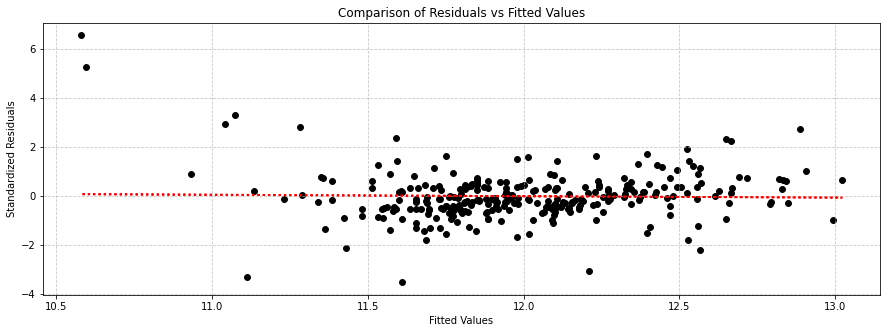

In [243]:
#Testing on LinearRegression() model
lin_reg.fit(y_pred.reshape(-1, 1), norm_residuals)

# Fit linear trendline for heteroskedasticity check
lin_reg = linear_model.LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), norm_residuals)  # Both are shape (292, 1)

trendline = lin_reg.predict(y_pred.reshape(-1, 1))  # Predict trendline on same x-values

# Plot
plt.figure(figsize=(15, 5))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Comparison of Residuals vs Fitted Values")
plt.scatter(y_pred, norm_residuals, c='black', s=35)
plt.plot(y_pred, trendline, color='red', linewidth=2, linestyle='dotted')
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.show()


/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


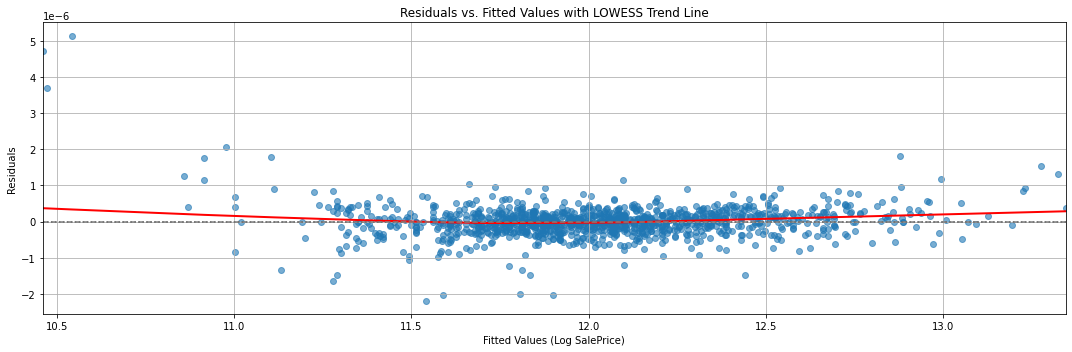

In [244]:
#Testing on ols() model

#Fitting to ols model
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Residuals vs. Fitted Values with LOWESS trend line
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(15, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 2}, 
              scatter_kws={'alpha': 0.6})
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted Values (Log SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values with LOWESS Trend Line")
plt.grid(True)
plt.tight_layout()
plt.show()

In [245]:
# Breusch-Pagan test for heteroskedasticity
bp       = het_breuschpagan(residuals, X_train)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')

for measure, value in zip(measures, bp):
    print(f"{measure}: {value}")

LM Statistic: 621.7376410617966
LM-Test p-value: 8.069972550703647e-28
F-Statistic: 4.3408947485334215
F-Test p-value: 1.154935126290134e-58


<h6 style="color: #ff5733;">Heteroskedasticity Findings:</h6>

1. The model is heteroskedastic as the residuals start off being closer to  the trendline while the house prices are upto $300,000. As the prices increase from there, the residuals also start fanning out. 

2. This implies that the prediction errors grow larger as house prices increase.

| Measure | Value | Conclusion |
| :--- | :--- | :--- |
| LM Statistic | 621.67 | Very high value, cannot be follow X^2 distribution under homoskedasticity |
| LM-Test p-value| 8.216 x 10^(-28)  | Lower than 0.05, confirms heteroskedasticity |
| F-Statistic | 4.33 | F-stat should be close to 0 for it be heteroskedastic distribition |
| F-Test p-value | 1.20 x 10^(-58) | Lower than 0.05, confirms heteroskedasticity |

**Conclusion:** The model can predict lower priced homes more accurately (<$300K) than more luxury homes. 

<h5 style="color: blue;">Test: Normal Q-Q</h5>

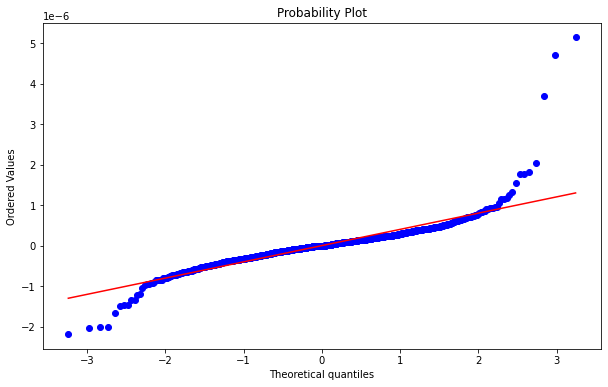

In [246]:
#Creat Q-Q plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

stats.probplot(residuals, dist = 'norm', plot = ax)
plt.show()


ax.set_title("Normal Q-Q Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_label("Ordered Values")

<h6 style="color: #ff5733;">Normal Q-Q Findings:</h6>

1. The residuals mostly follow the red line closely, especially in the middle of the distribution (around theoretical quantiles -2 to 2). This suggests that the central part of our distribution aligns with a normal distribution.

2. The deviation at the lower tail (below -2) implies that the lower end of the data has smaller values than expected
3. The deviation at the upper tail (above 2) implies upper end of the data has larger than anticipated values

**Conclusion:** The model predictions aren't entirely normally distributed and outliers 

<h5 style="color: blue;">Test: MAE & RMSE</h5>

In [247]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"""
MAE: {mae:.2f} 
RMSE: {rmse:.2f}
""")


MAE: 0.00 
RMSE: 0.00



In [248]:
mean_price = y.mean() 
mae_percent = (mae / mean_price) * 100
rmse_percent = (rmse / mean_price) * 100

print(f"""
MAE is {mae_percent:.1f}% of mean 
RMSE is {rmse_percent:.1f}% of mean
""")


MAE is 0.0% of mean 
RMSE is 0.0% of mean



<h6 style="color: #ff5733;">MAE & RMSE Findings:</h6>

